### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, load_model_config
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

#### Data loading

In [3]:
dataset_name = "beam"

x_LF, x_HF = load_data(
    dataset_name,
    preprocess=True,
    normalize=False, 
    flatten=True,
)
print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading beam data ...
x_LF.shape=(10000, 513) x_HF.shape=(10000, 513)


### Plot data 

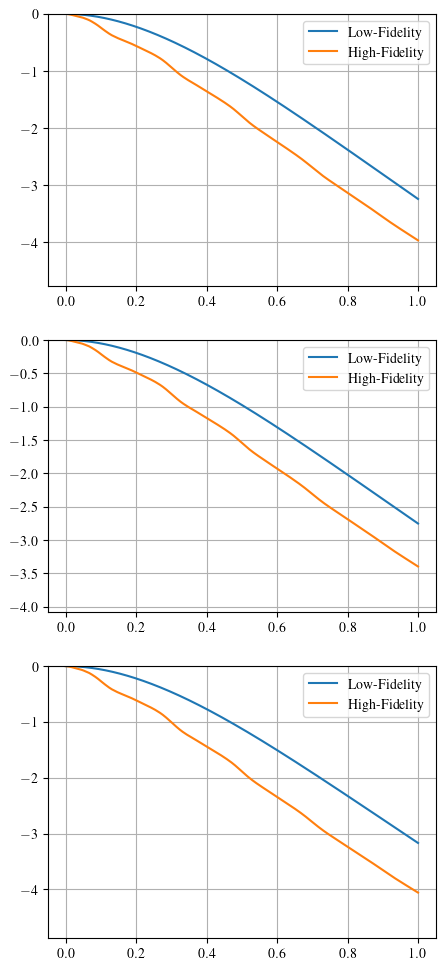

In [4]:
plot_data(x_LF, x_HF, dataset_name, n_samples=3)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full'
}
model = MultiFidelityModel(**model_config)

#### Perform spectral clustering

In [6]:
n_HF = 50
inds_train, labels = model.cluster(g_LF, n_HF)

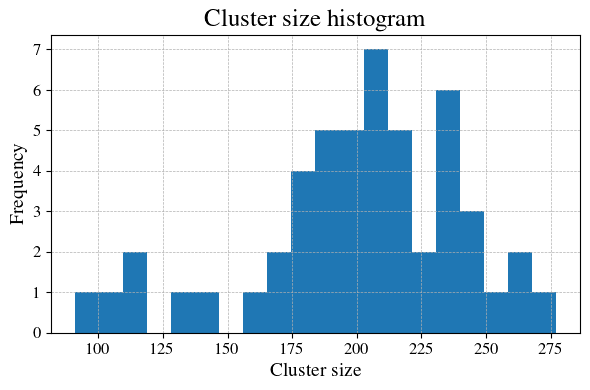

In [7]:
plot_cluster_size_hist(labels)

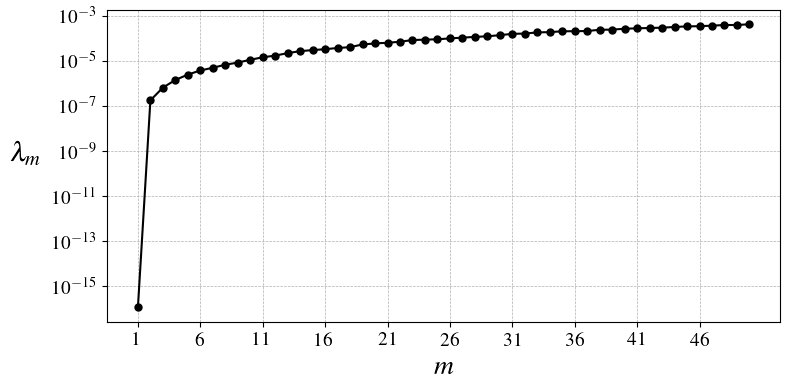

In [8]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Split high-fidelity data

In [9]:
n_samples = x_HF.shape[0]
inds_test = np.delete(np.arange(n_samples), inds_train)
x_HF_train = x_HF[inds_train, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(50, 513) x_HF_test.shape=(9950, 513)


#### Fit and train the model

In [10]:
fit_model = True

Iteration: 0, Loss: 0.0005580875046764545, Gradient: 3.572674252038301e-05, Kappa: 0.0006995853859520885
Iteration: 1, Loss: 0.0005451187643986175, Gradient: 3.688237254143364e-05, Kappa: 0.0004928009375111902
Iteration: 2, Loss: 0.0005319881293042265, Gradient: 3.807962913677015e-05, Kappa: 0.00034947661923261005
Iteration: 3, Loss: 0.0005186893529028377, Gradient: 3.9325695901116484e-05, Kappa: 0.0002494523653300626
Iteration: 4, Loss: 0.0005052133917478708, Gradient: 4.062358411537029e-05, Kappa: 0.0001791791861089525
Iteration: 5, Loss: 0.0004915493208859568, Gradient: 4.198496502306575e-05, Kappa: 0.00012947847989130663
Iteration: 6, Loss: 0.0004776771540094445, Gradient: 4.343930130666285e-05, Kappa: 9.408474396108655e-05
Iteration: 7, Loss: 0.00046355651227289593, Gradient: 4.5036385253796204e-05, Kappa: 6.869593537259017e-05
Iteration: 8, Loss: 0.00044911485572146783, Gradient: 4.6848024024424366e-05, Kappa: 5.034456503089305e-05
Iteration: 9, Loss: 0.00043423414638530517, Grad

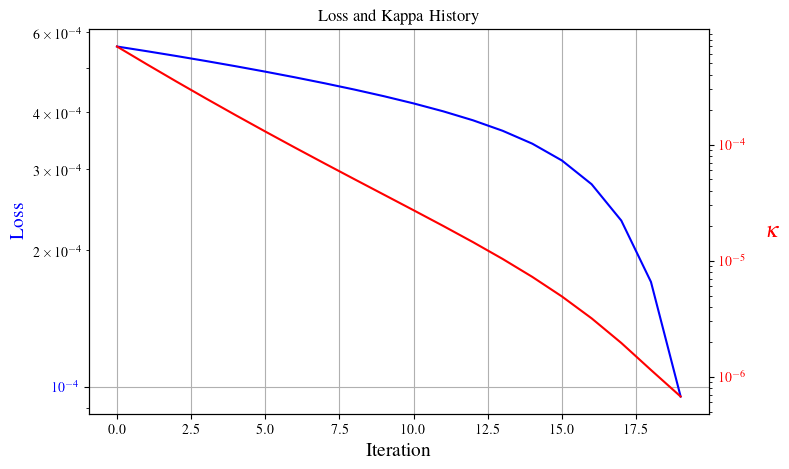

In [40]:
if fit_model:
    (x_MF, C_phi, dPhi), loss_history, kappa_history = model.fit_transform(
        g_LF,
        x_HF_train,
        inds_train,
        maxiter=20,
        step_size=1e4,
        step_decay_rate=0.95,
        ftol=1e-6,
        gtol=1e-8,
        verbose=True,
    )
    model.summary()

    iterations = np.arange(len(loss_history))
    plot_loss_and_kappa(iterations, loss_history, kappa_history)

else:
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent / 'data/model_configs.yaml'
    model_config = load_model_config(yaml_file_path, dataset_name)
    model = MultiFidelityModel(**model_config)
    
    if model_config:
        x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
        model.summary()

Text(0.5, 1.0, 'Variance histogram Beam data')

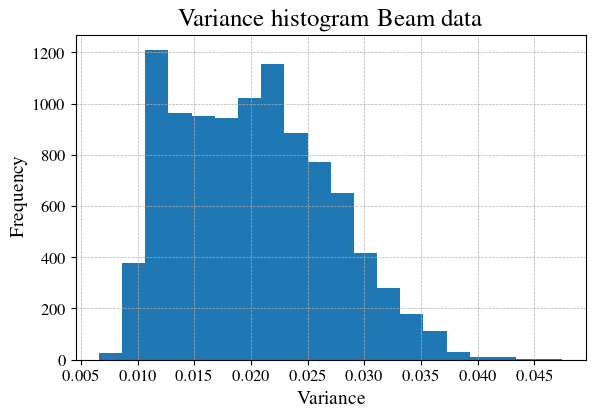

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram Beam data", fontsize=18)

### Results

In [42]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         30.7
Error MF:         4.46
Percentage drop:  85.49%


In [43]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         30.7
Error MF:         4.43
Percentage drop:  85.56%


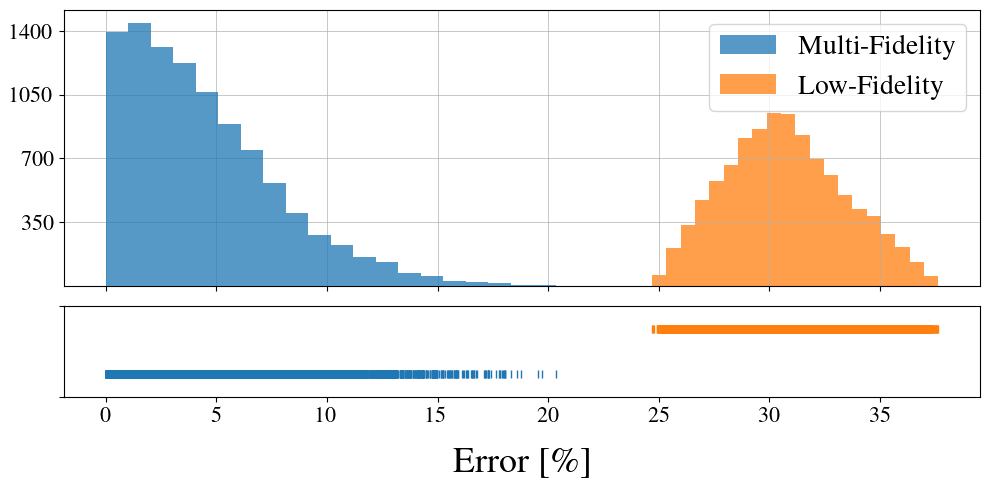

In [44]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=20, bins_MF=20, mask=None)

Samples: [2821 4181 1349 8026]


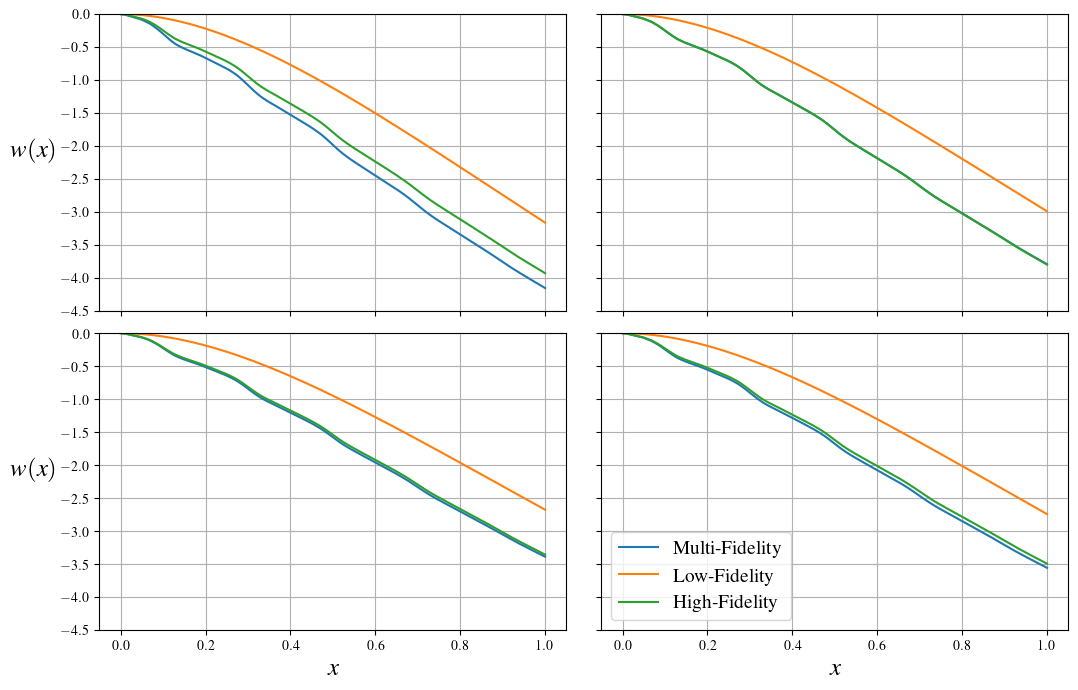

In [45]:
x_values = np.linspace(0, 1, x_LF[0, :].shape[0])
xlabel = r"$x$"
ylabel = r"$w(x)$"
ymin, ymax = -4.5, 0

plot_mf_comparison(
    dataset_name=dataset_name,
    X_LF=x_LF,
    X_MF=x_MF,
    X_HF=x_HF,
    x_values=x_values,
    xlabel=xlabel,
    ylabel=ylabel,
    ymin=ymin,
    ymax=ymax,
    legend_loc="lower left",
)

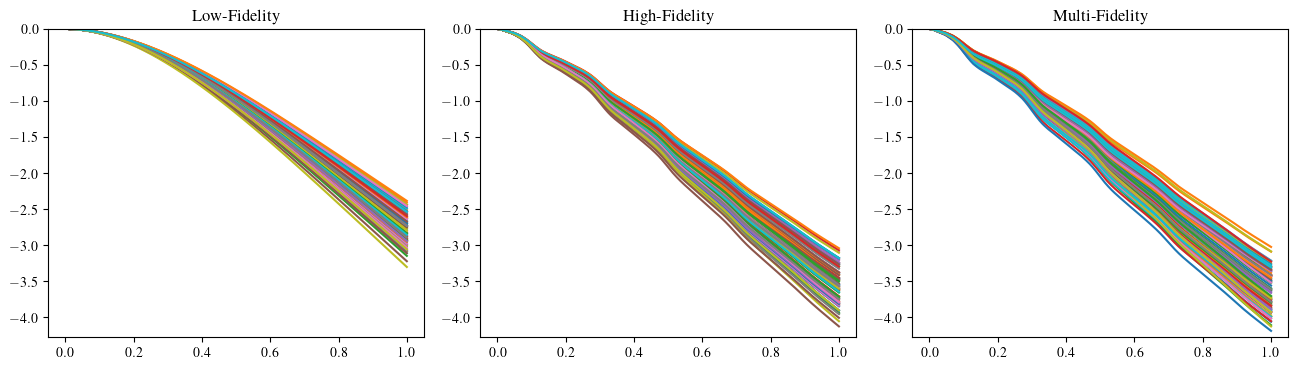

In [46]:
n_points, _ = x_LF.shape
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.subplots_adjust(wspace=0.15)
vmin, vmax = 1. * np.min((x_LF, x_HF)), 1.2 * np.max((x_LF, x_HF))
for i in range(100):
    j = np.random.randint(0, n_points)
    x_ = np.linspace(0, 1, x_LF[j, :].shape[0])
    axs[0].plot(x_, x_LF[j, :], label="Low-Fidelity")
    axs[0].set_title("Low-Fidelity")
    axs[1].plot(x_, x_HF[j, :], label="High-Fidelity")
    axs[1].set_title("High-Fidelity")
    axs[2].plot(x_, x_MF[j, :], label="Multi-Fidelity")
    axs[2].set_title("Multi-Fidelity")
    axs[0].set_ylim((vmin, vmax))
    axs[1].set_ylim((vmin, vmax))
    axs[2].set_ylim((vmin, vmax))

### Explore UQ applications

In [23]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [24]:
_, eigevs = g_LF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [25]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=1,
    init='random', 
    random_state=42
).fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/generic-env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP of Cantilever Beam data (Case 4)')

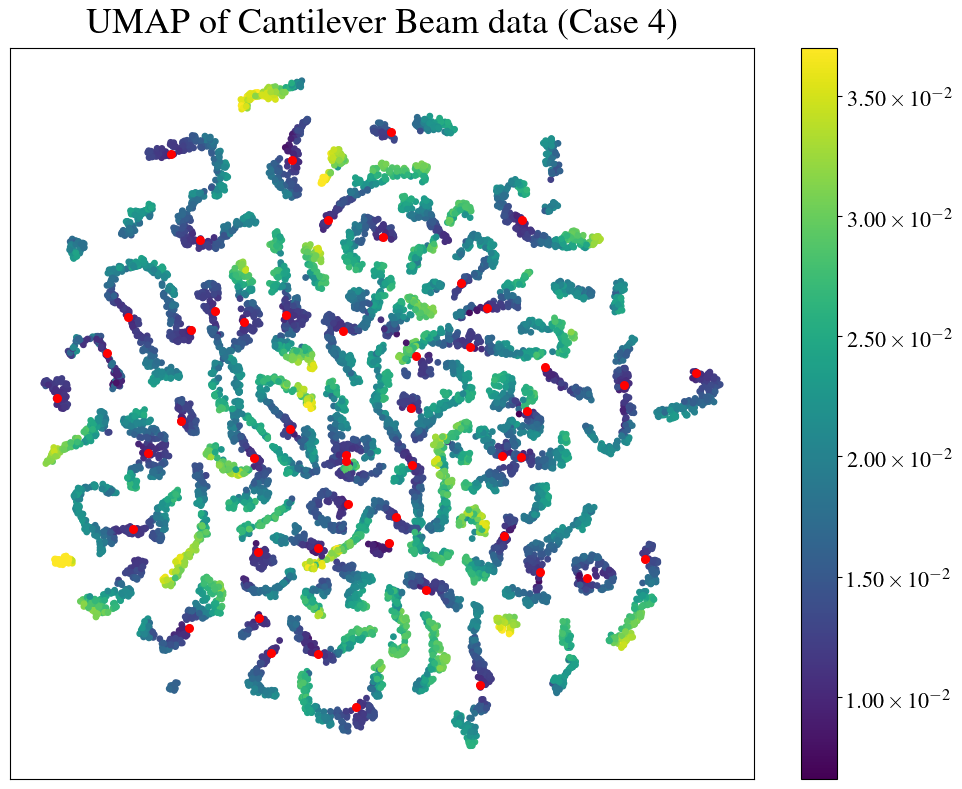

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, vmax=0.037)
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Cantilever Beam data (Case 4)', fontsize=26, pad=10)